In [3]:
import numpy as np
import pyxdf
import matplotlib.pyplot as plt
from scipy import signal, fftpack

import mne 


In [163]:
## import no-tacs data

data, header=  pyxdf.load_xdf('../recordings/P02-no-tacs-R1.xdf')

makers_data = data[0] 
opm_data = data[1]
fs = 1000 # sampling rate 


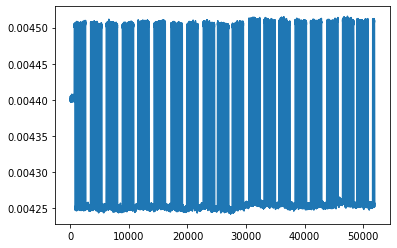

In [185]:
start = 10 # seconds in 
end = 10 #seocnds before it ends
opm_data_cut = opm_data['time_series'][start*fs:-end*fs, :]

plt.plot(opm_data_cut[:, 0])

In [213]:
# for x in opm_data['info']['desc']: 
#     print(x['chassis']['ch'])

# print(opm_data['info']['desc'][0]['chassis'][0]['chassis'][0])
print(opm_data['info']['desc'][0]['channels'][0]['channel'][0])
print(opm_data['info']['desc'][0]['channels'][0]['channel'][0])

defaultdict(<class 'list'>, {'label': ['00:00:0'], 'chassis_id': ['0'], 'sensor_id': ['0'], 'calibration': ['2.980232238769531e-07'], 'type': ['misc'], 'unit': ['V'], 'mode': ['ADC']})
